## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
if torch.cuda.is_available():
    net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36992, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

# data_transform = transforms.Compose([
#                          Rescale((128,128)),
#                          Normalize(),    
#                         ToTensor()])

# data_transform = transforms.Compose([Rescale(250),
#                                      RandomCrop(224),
#                                      Normalize(),
#                                      ToTensor()])

data_transform = transforms.Compose([Rescale(180),
                                     RandomCrop(168),
                                     Normalize(),
                                     ToTensor()])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 168, 168]) torch.Size([68, 2])
1 torch.Size([1, 168, 168]) torch.Size([68, 2])
2 torch.Size([1, 168, 168]) torch.Size([68, 2])
3 torch.Size([1, 168, 168]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 168, 168])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

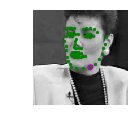

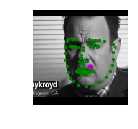

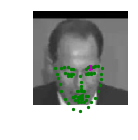

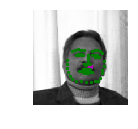

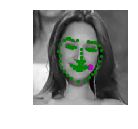

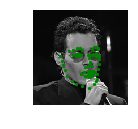

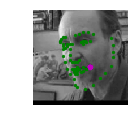

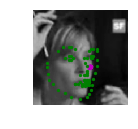

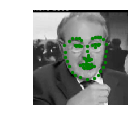

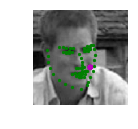

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if torch.cuda.is_available():
            predicted_key_pts = predicted_key_pts.cpu() 
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss() #nn.SmoothL1Loss

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    train_losses , train_accuracy = [],[]    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            if torch.cuda.is_available():
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)            
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 60 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0028925290405750273
Epoch: 1, Batch: 20, Avg. Loss: 0.003166220396757126
Epoch: 1, Batch: 30, Avg. Loss: 0.0030808843374252317
Epoch: 1, Batch: 40, Avg. Loss: 0.0026768472790718078
Epoch: 1, Batch: 50, Avg. Loss: 0.002885620817542076
Epoch: 1, Batch: 60, Avg. Loss: 0.0029266490936279295
Epoch: 1, Batch: 70, Avg. Loss: 0.0030407278090715407
Epoch: 1, Batch: 80, Avg. Loss: 0.0026776740103960036
Epoch: 1, Batch: 90, Avg. Loss: 0.0028892028778791426
Epoch: 1, Batch: 100, Avg. Loss: 0.0029580632746219635
Epoch: 1, Batch: 110, Avg. Loss: 0.0029190818071365356
Epoch: 1, Batch: 120, Avg. Loss: 0.00306853611767292
Epoch: 1, Batch: 130, Avg. Loss: 0.002928696021437645
Epoch: 1, Batch: 140, Avg. Loss: 0.00294718499481678
Epoch: 1, Batch: 150, Avg. Loss: 0.002682700350880623
Epoch: 1, Batch: 160, Avg. Loss: 0.002734532728791237
Epoch: 1, Batch: 170, Avg. Loss: 0.0026810524016618728
Epoch: 1, Batch: 180, Avg. Loss: 0.0028757292181253434
Epoch: 1, Batch: 190, Avg. L

Epoch: 5, Batch: 160, Avg. Loss: 0.0007984797284007072
Epoch: 5, Batch: 170, Avg. Loss: 0.0006889059729874134
Epoch: 5, Batch: 180, Avg. Loss: 0.0010045840702950955
Epoch: 5, Batch: 190, Avg. Loss: 0.0008618049994111062
Epoch: 5, Batch: 200, Avg. Loss: 0.0008211767040193081
Epoch: 5, Batch: 210, Avg. Loss: 0.0009648250676691533
Epoch: 5, Batch: 220, Avg. Loss: 0.0008542921021580696
Epoch: 5, Batch: 230, Avg. Loss: 0.0011843399703502656
Epoch: 5, Batch: 240, Avg. Loss: 0.0008470951914787292
Epoch: 5, Batch: 250, Avg. Loss: 0.0012727391347289085
Epoch: 5, Batch: 260, Avg. Loss: 0.0008456965684890747
Epoch: 5, Batch: 270, Avg. Loss: 0.0013969243429601192
Epoch: 5, Batch: 280, Avg. Loss: 0.0008516775257885456
Epoch: 5, Batch: 290, Avg. Loss: 0.0007246952056884766
Epoch: 5, Batch: 300, Avg. Loss: 0.0008223675377666951
Epoch: 5, Batch: 310, Avg. Loss: 0.0007686528228223324
Epoch: 5, Batch: 320, Avg. Loss: 0.0009412516430020333
Epoch: 5, Batch: 330, Avg. Loss: 0.0007281915694475173
Epoch: 5, 

Epoch: 9, Batch: 300, Avg. Loss: 0.0011193880885839462
Epoch: 9, Batch: 310, Avg. Loss: 0.0008363024070858955
Epoch: 9, Batch: 320, Avg. Loss: 0.0007076486833393574
Epoch: 9, Batch: 330, Avg. Loss: 0.0008343428559601306
Epoch: 9, Batch: 340, Avg. Loss: 0.0007639139145612716
Epoch: 10, Batch: 10, Avg. Loss: 0.0007587821334600448
Epoch: 10, Batch: 20, Avg. Loss: 0.0008837867602705955
Epoch: 10, Batch: 30, Avg. Loss: 0.0007621656097471714
Epoch: 10, Batch: 40, Avg. Loss: 0.0007283847630023956
Epoch: 10, Batch: 50, Avg. Loss: 0.0012074129693210125
Epoch: 10, Batch: 60, Avg. Loss: 0.0008318936266005039
Epoch: 10, Batch: 70, Avg. Loss: 0.0015528226457536222
Epoch: 10, Batch: 80, Avg. Loss: 0.0007474472094327211
Epoch: 10, Batch: 90, Avg. Loss: 0.0009350343570113182
Epoch: 10, Batch: 100, Avg. Loss: 0.0010762964263558387
Epoch: 10, Batch: 110, Avg. Loss: 0.0007678542174398899
Epoch: 10, Batch: 120, Avg. Loss: 0.0008821829408407211
Epoch: 10, Batch: 130, Avg. Loss: 0.000922906331717968
Epoch: 

Epoch: 14, Batch: 80, Avg. Loss: 0.0010272247456014157
Epoch: 14, Batch: 90, Avg. Loss: 0.0009833791926503182
Epoch: 14, Batch: 100, Avg. Loss: 0.000782421350479126
Epoch: 14, Batch: 110, Avg. Loss: 0.000863682109862566
Epoch: 14, Batch: 120, Avg. Loss: 0.0008095507808029652
Epoch: 14, Batch: 130, Avg. Loss: 0.0013755569644272327
Epoch: 14, Batch: 140, Avg. Loss: 0.000770010694861412
Epoch: 14, Batch: 150, Avg. Loss: 0.0007966779209673405
Epoch: 14, Batch: 160, Avg. Loss: 0.001118729967623949
Epoch: 14, Batch: 170, Avg. Loss: 0.0008996771164238453
Epoch: 14, Batch: 180, Avg. Loss: 0.0009012595601379872
Epoch: 14, Batch: 190, Avg. Loss: 0.0009642420299351216
Epoch: 14, Batch: 200, Avg. Loss: 0.0008350158929824829
Epoch: 14, Batch: 210, Avg. Loss: 0.0008275692909955978
Epoch: 14, Batch: 220, Avg. Loss: 0.000619576059281826
Epoch: 14, Batch: 230, Avg. Loss: 0.0008821939378976822
Epoch: 14, Batch: 240, Avg. Loss: 0.001002414993941784
Epoch: 14, Batch: 250, Avg. Loss: 0.0008517667427659035


Epoch: 18, Batch: 200, Avg. Loss: 0.0007470365650951862
Epoch: 18, Batch: 210, Avg. Loss: 0.0007252957150340081
Epoch: 18, Batch: 220, Avg. Loss: 0.0007978982962667942
Epoch: 18, Batch: 230, Avg. Loss: 0.0007391098029911518
Epoch: 18, Batch: 240, Avg. Loss: 0.0010993293486535548
Epoch: 18, Batch: 250, Avg. Loss: 0.0008631325699388981
Epoch: 18, Batch: 260, Avg. Loss: 0.0008760000392794609
Epoch: 18, Batch: 270, Avg. Loss: 0.0008615016900002956
Epoch: 18, Batch: 280, Avg. Loss: 0.000753793228417635
Epoch: 18, Batch: 290, Avg. Loss: 0.0008086673058569432
Epoch: 18, Batch: 300, Avg. Loss: 0.0007832897305488587
Epoch: 18, Batch: 310, Avg. Loss: 0.0012138802781701088
Epoch: 18, Batch: 320, Avg. Loss: 0.001077745407819748
Epoch: 18, Batch: 330, Avg. Loss: 0.0008548908866941929
Epoch: 18, Batch: 340, Avg. Loss: 0.0008754157088696956
Epoch: 19, Batch: 10, Avg. Loss: 0.0009557579569518566
Epoch: 19, Batch: 20, Avg. Loss: 0.001098839771002531
Epoch: 19, Batch: 30, Avg. Loss: 0.001086501035839319

Epoch: 22, Batch: 320, Avg. Loss: 0.0009576737172901631
Epoch: 22, Batch: 330, Avg. Loss: 0.0009578307233750821
Epoch: 22, Batch: 340, Avg. Loss: 0.0008594068214297294
Epoch: 23, Batch: 10, Avg. Loss: 0.0008993737511336804
Epoch: 23, Batch: 20, Avg. Loss: 0.0007434438169002533
Epoch: 23, Batch: 30, Avg. Loss: 0.0006692868880927563
Epoch: 23, Batch: 40, Avg. Loss: 0.0008829278461635113
Epoch: 23, Batch: 50, Avg. Loss: 0.0007872501276433468
Epoch: 23, Batch: 60, Avg. Loss: 0.0009431090392172337
Epoch: 23, Batch: 70, Avg. Loss: 0.0008760662525892258
Epoch: 23, Batch: 80, Avg. Loss: 0.0008460022769868374
Epoch: 23, Batch: 90, Avg. Loss: 0.0008355600498616695
Epoch: 23, Batch: 100, Avg. Loss: 0.0006604621447622776
Epoch: 23, Batch: 110, Avg. Loss: 0.0008619818724691868
Epoch: 23, Batch: 120, Avg. Loss: 0.0018094214275479316
Epoch: 23, Batch: 130, Avg. Loss: 0.0006891436427831649
Epoch: 23, Batch: 140, Avg. Loss: 0.0008058652244508266
Epoch: 23, Batch: 150, Avg. Loss: 0.001043686356395483
Ep

Epoch: 27, Batch: 100, Avg. Loss: 0.0009104858450591564
Epoch: 27, Batch: 110, Avg. Loss: 0.0009760927706956863
Epoch: 27, Batch: 120, Avg. Loss: 0.0008118906468153
Epoch: 27, Batch: 130, Avg. Loss: 0.0009125223606824875
Epoch: 27, Batch: 140, Avg. Loss: 0.0009055592529475689
Epoch: 27, Batch: 150, Avg. Loss: 0.0008658985532820224
Epoch: 27, Batch: 160, Avg. Loss: 0.0007781652957201004
Epoch: 27, Batch: 170, Avg. Loss: 0.0013150071240961552
Epoch: 27, Batch: 180, Avg. Loss: 0.0007254341542720794
Epoch: 27, Batch: 190, Avg. Loss: 0.0010314023271203042
Epoch: 27, Batch: 200, Avg. Loss: 0.0008876735344529151
Epoch: 27, Batch: 210, Avg. Loss: 0.0008765238523483276
Epoch: 27, Batch: 220, Avg. Loss: 0.001010945450514555
Epoch: 27, Batch: 230, Avg. Loss: 0.0006951466910541058
Epoch: 27, Batch: 240, Avg. Loss: 0.000742561224848032
Epoch: 27, Batch: 250, Avg. Loss: 0.0006862904243171215
Epoch: 27, Batch: 260, Avg. Loss: 0.0007471552416682244
Epoch: 27, Batch: 270, Avg. Loss: 0.00126018813624978

Epoch: 31, Batch: 220, Avg. Loss: 0.0007370245642960071
Epoch: 31, Batch: 230, Avg. Loss: 0.0008299461863934994
Epoch: 31, Batch: 240, Avg. Loss: 0.0008229505121707916
Epoch: 31, Batch: 250, Avg. Loss: 0.0007848158366978168
Epoch: 31, Batch: 260, Avg. Loss: 0.0006922106333076954
Epoch: 31, Batch: 270, Avg. Loss: 0.0007270497269928455
Epoch: 31, Batch: 280, Avg. Loss: 0.0008841008730232716
Epoch: 31, Batch: 290, Avg. Loss: 0.00108305337280035
Epoch: 31, Batch: 300, Avg. Loss: 0.0008544017262756825
Epoch: 31, Batch: 310, Avg. Loss: 0.0007653480619192124
Epoch: 31, Batch: 320, Avg. Loss: 0.0009533843286335469
Epoch: 31, Batch: 330, Avg. Loss: 0.0008869583122432232
Epoch: 31, Batch: 340, Avg. Loss: 0.0007540924176573753
Epoch: 32, Batch: 10, Avg. Loss: 0.000993764951825142
Epoch: 32, Batch: 20, Avg. Loss: 0.0007375788427889347
Epoch: 32, Batch: 30, Avg. Loss: 0.0008365166783332825
Epoch: 32, Batch: 40, Avg. Loss: 0.0009247437566518783
Epoch: 32, Batch: 50, Avg. Loss: 0.0012047514021396638


Epoch: 35, Batch: 340, Avg. Loss: 0.0008543989919126034
Epoch: 36, Batch: 10, Avg. Loss: 0.0008186493776738644
Epoch: 36, Batch: 20, Avg. Loss: 0.0008212678842246532
Epoch: 36, Batch: 30, Avg. Loss: 0.0006650766283273696
Epoch: 36, Batch: 40, Avg. Loss: 0.0008439054340124131
Epoch: 36, Batch: 50, Avg. Loss: 0.0009414357356727123
Epoch: 36, Batch: 60, Avg. Loss: 0.0007705817595124244
Epoch: 36, Batch: 70, Avg. Loss: 0.0010078826658427716
Epoch: 36, Batch: 80, Avg. Loss: 0.0009649776630103589
Epoch: 36, Batch: 90, Avg. Loss: 0.0009679812379181385
Epoch: 36, Batch: 100, Avg. Loss: 0.0007575092911720276
Epoch: 36, Batch: 110, Avg. Loss: 0.0010667220838367938
Epoch: 36, Batch: 120, Avg. Loss: 0.0007744759209454059
Epoch: 36, Batch: 130, Avg. Loss: 0.0008082341216504574
Epoch: 36, Batch: 140, Avg. Loss: 0.0007589748129248619
Epoch: 36, Batch: 150, Avg. Loss: 0.0007769329883158207
Epoch: 36, Batch: 160, Avg. Loss: 0.0008412429504096508
Epoch: 36, Batch: 170, Avg. Loss: 0.0009016135185956955
E

Epoch: 40, Batch: 120, Avg. Loss: 0.0006961147412657738
Epoch: 40, Batch: 130, Avg. Loss: 0.0008721303939819336
Epoch: 40, Batch: 140, Avg. Loss: 0.0009419555775821209
Epoch: 40, Batch: 150, Avg. Loss: 0.0007071264255791902
Epoch: 40, Batch: 160, Avg. Loss: 0.0010653423480689525
Epoch: 40, Batch: 170, Avg. Loss: 0.0008825032934546471
Epoch: 40, Batch: 180, Avg. Loss: 0.001173064023256302
Epoch: 40, Batch: 190, Avg. Loss: 0.0007218173332512378
Epoch: 40, Batch: 200, Avg. Loss: 0.0007514110542833805
Epoch: 40, Batch: 210, Avg. Loss: 0.0009358623400330543
Epoch: 40, Batch: 220, Avg. Loss: 0.0007876293994486332
Epoch: 40, Batch: 230, Avg. Loss: 0.000652610719203949
Epoch: 40, Batch: 240, Avg. Loss: 0.0008490996845066548
Epoch: 40, Batch: 250, Avg. Loss: 0.0006446064189076423
Epoch: 40, Batch: 260, Avg. Loss: 0.0007952854186296463
Epoch: 40, Batch: 270, Avg. Loss: 0.000807975172996521
Epoch: 40, Batch: 280, Avg. Loss: 0.0007856306545436382
Epoch: 40, Batch: 290, Avg. Loss: 0.000822227660566

Epoch: 44, Batch: 240, Avg. Loss: 0.0007679390981793403
Epoch: 44, Batch: 250, Avg. Loss: 0.0008601506985723973
Epoch: 44, Batch: 260, Avg. Loss: 0.0007810175865888596
Epoch: 44, Batch: 270, Avg. Loss: 0.000877409614622593
Epoch: 44, Batch: 280, Avg. Loss: 0.0006727298460900784
Epoch: 44, Batch: 290, Avg. Loss: 0.0007801491841673851
Epoch: 44, Batch: 300, Avg. Loss: 0.0008800802268087864
Epoch: 44, Batch: 310, Avg. Loss: 0.0007900977842509746
Epoch: 44, Batch: 320, Avg. Loss: 0.0009288289919495582
Epoch: 44, Batch: 330, Avg. Loss: 0.0007602798566222191
Epoch: 44, Batch: 340, Avg. Loss: 0.0009055378884077072
Epoch: 45, Batch: 10, Avg. Loss: 0.0009130247943103314
Epoch: 45, Batch: 20, Avg. Loss: 0.0006892355158925056
Epoch: 45, Batch: 30, Avg. Loss: 0.0008680120334029198
Epoch: 45, Batch: 40, Avg. Loss: 0.0007818343788385391
Epoch: 45, Batch: 50, Avg. Loss: 0.0006759258788079024
Epoch: 45, Batch: 60, Avg. Loss: 0.0007600835338234901
Epoch: 45, Batch: 70, Avg. Loss: 0.0007359636276960373


Epoch: 49, Batch: 20, Avg. Loss: 0.0012079522386193276
Epoch: 49, Batch: 30, Avg. Loss: 0.000923426453024149
Epoch: 49, Batch: 40, Avg. Loss: 0.0008365494199097156
Epoch: 49, Batch: 50, Avg. Loss: 0.0008085811026394367
Epoch: 49, Batch: 60, Avg. Loss: 0.0009813608601689338
Epoch: 49, Batch: 70, Avg. Loss: 0.0008154902011156082
Epoch: 49, Batch: 80, Avg. Loss: 0.0006316818855702877
Epoch: 49, Batch: 90, Avg. Loss: 0.0007843357026576995
Epoch: 49, Batch: 100, Avg. Loss: 0.0009445513673126697
Epoch: 49, Batch: 110, Avg. Loss: 0.0008018914684653283
Epoch: 49, Batch: 120, Avg. Loss: 0.000895063940435648
Epoch: 49, Batch: 130, Avg. Loss: 0.000846076313406229
Epoch: 49, Batch: 140, Avg. Loss: 0.0013728720881044864
Epoch: 49, Batch: 150, Avg. Loss: 0.0008580556735396385
Epoch: 49, Batch: 160, Avg. Loss: 0.0008469973057508469
Epoch: 49, Batch: 170, Avg. Loss: 0.0008984108157455922
Epoch: 49, Batch: 180, Avg. Loss: 0.0009880178458988667
Epoch: 49, Batch: 190, Avg. Loss: 0.0009550514295697212
Epo

Epoch: 53, Batch: 140, Avg. Loss: 0.0008035540618002415
Epoch: 53, Batch: 150, Avg. Loss: 0.0008172228373587131
Epoch: 53, Batch: 160, Avg. Loss: 0.0007591083198785781
Epoch: 53, Batch: 170, Avg. Loss: 0.0008960953839123249
Epoch: 53, Batch: 180, Avg. Loss: 0.0008903454057872295
Epoch: 53, Batch: 190, Avg. Loss: 0.000984932839870453
Epoch: 53, Batch: 200, Avg. Loss: 0.0009482936523854732
Epoch: 53, Batch: 210, Avg. Loss: 0.0008180395923554898
Epoch: 53, Batch: 220, Avg. Loss: 0.0008319762870669365
Epoch: 53, Batch: 230, Avg. Loss: 0.0007609467320144177
Epoch: 53, Batch: 240, Avg. Loss: 0.0008061311841011048
Epoch: 53, Batch: 250, Avg. Loss: 0.0008785017468035221
Epoch: 53, Batch: 260, Avg. Loss: 0.0007847100906074047
Epoch: 53, Batch: 270, Avg. Loss: 0.000991973079741001
Epoch: 53, Batch: 280, Avg. Loss: 0.0006823975220322609
Epoch: 53, Batch: 290, Avg. Loss: 0.0008980424851179122
Epoch: 53, Batch: 300, Avg. Loss: 0.0007891313768923282
Epoch: 53, Batch: 310, Avg. Loss: 0.00092227009683

Epoch: 57, Batch: 260, Avg. Loss: 0.0007490586638450623
Epoch: 57, Batch: 270, Avg. Loss: 0.0007698881216347218
Epoch: 57, Batch: 280, Avg. Loss: 0.0007396283764392138
Epoch: 57, Batch: 290, Avg. Loss: 0.0008874467350542545
Epoch: 57, Batch: 300, Avg. Loss: 0.0008010035678744316
Epoch: 57, Batch: 310, Avg. Loss: 0.000824031051248312
Epoch: 57, Batch: 320, Avg. Loss: 0.0010545086078345776
Epoch: 57, Batch: 330, Avg. Loss: 0.0008319973945617676
Epoch: 57, Batch: 340, Avg. Loss: 0.000917616805061698
Epoch: 58, Batch: 10, Avg. Loss: 0.000834089633077383
Epoch: 58, Batch: 20, Avg. Loss: 0.0007083320543169975
Epoch: 58, Batch: 30, Avg. Loss: 0.0008838887475430965
Epoch: 58, Batch: 40, Avg. Loss: 0.001062232069671154
Epoch: 58, Batch: 50, Avg. Loss: 0.0008861592337489128
Epoch: 58, Batch: 60, Avg. Loss: 0.000832063589245081
Epoch: 58, Batch: 70, Avg. Loss: 0.0008114761039614678
Epoch: 58, Batch: 80, Avg. Loss: 0.0007796675525605679
Epoch: 58, Batch: 90, Avg. Loss: 0.0007726997174322605
Epoch:

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 168, 168])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


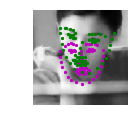

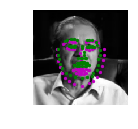

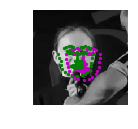

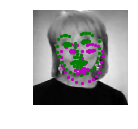

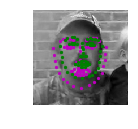

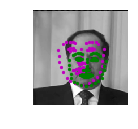

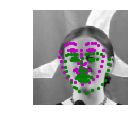

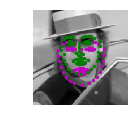

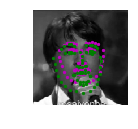

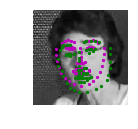

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

In [17]:
print(test_outputs[0])

tensor([[-1.0716, -0.5542],
        [-1.0525, -0.3513],
        [-1.0113, -0.1758],
        [-0.9733,  0.0025],
        [-0.8901,  0.1941],
        [-0.7806,  0.3491],
        [-0.6691,  0.4582],
        [-0.4875,  0.5537],
        [-0.2634,  0.5993],
        [-0.0284,  0.5490],
        [ 0.1207,  0.4263],
        [ 0.2506,  0.3370],
        [ 0.3227,  0.1861],
        [ 0.3937, -0.0195],
        [ 0.4302, -0.1987],
        [ 0.4570, -0.3832],
        [ 0.4574, -0.5794],
        [-0.8877, -0.7429],
        [-0.7903, -0.8112],
        [-0.6791, -0.8307],
        [-0.5942, -0.8057],
        [-0.4869, -0.7860],
        [-0.1326, -0.7968],
        [-0.0306, -0.8219],
        [ 0.0597, -0.8115],
        [ 0.1752, -0.8240],
        [ 0.2639, -0.7624],
        [-0.3024, -0.5742],
        [-0.3066, -0.4441],
        [-0.2894, -0.3123],
        [-0.2886, -0.2203],
        [-0.4217, -0.1236],
        [-0.3488, -0.1036],
        [-0.2846, -0.1017],
        [-0.2092, -0.1221],
        [-0.1701, -0

Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_60.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [19]:
# # Get the weights in the first conv layer, "conv1"
# # if necessary, change this to reflect the name of your first conv layer
# weights1 = net.conv1.weight.data

# w = weights1.numpy()

# filter_index = 0

# print(w[filter_index][0])
# print(w[filter_index][0].shape)

# # display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')

First convolutional layer


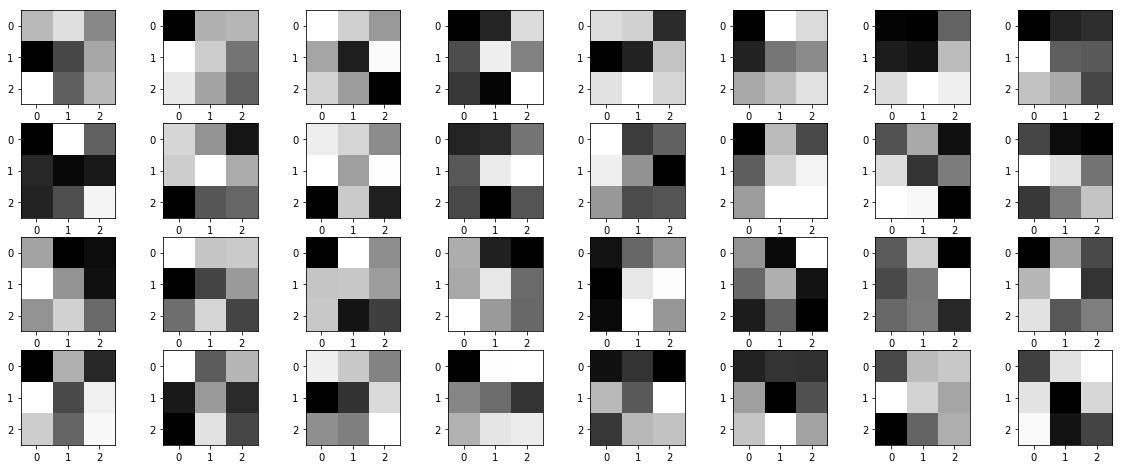

In [20]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
weights = weights.cpu() if torch.cuda.is_available() else weights
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 8
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [21]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


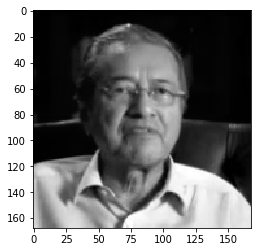

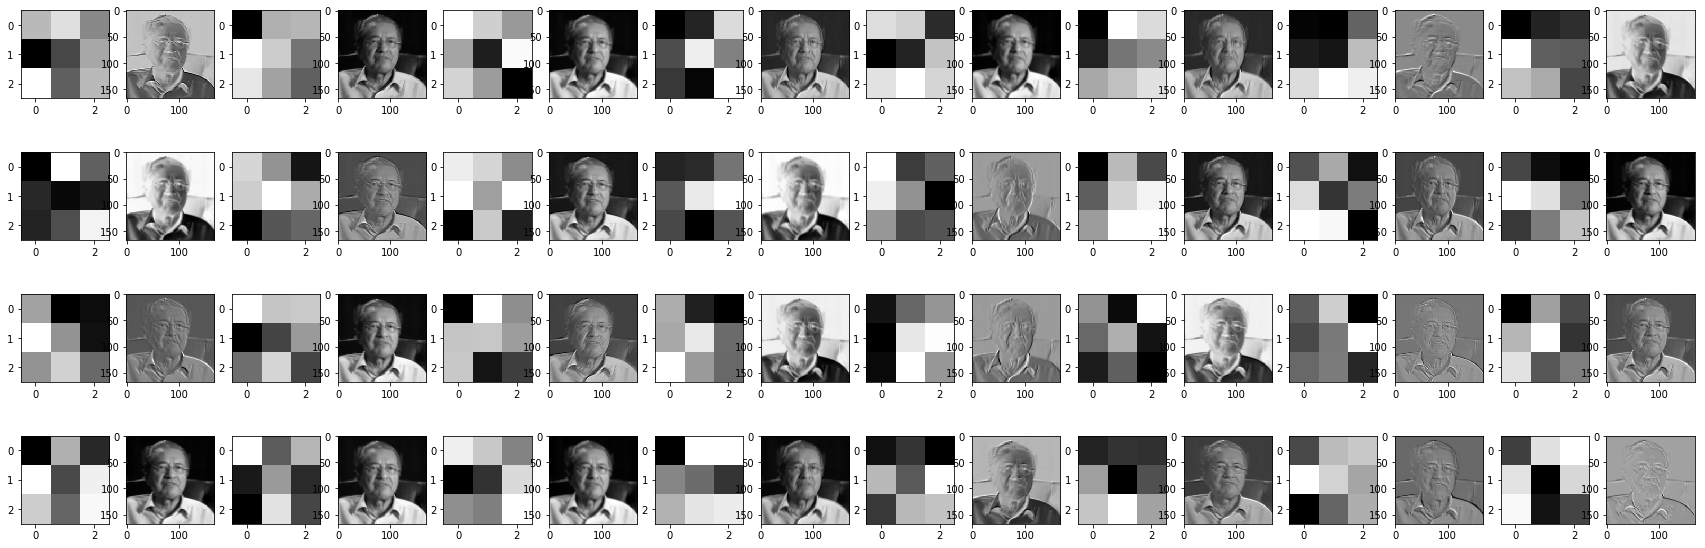

In [22]:
# select an image by index
idx = 1
image = test_images[idx].data   # get the image from it's wrapper
image = image.cpu() if torch.cuda.is_available() else image
image = image.numpy()   # convert to numpy array from a Tensor
img = np.squeeze(image)

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
weights = weights.cpu() if torch.cuda.is_available() else weights
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 8 * 2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!